# [Homework 4](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week04.pdf)

In [1]:
import jax.numpy as np
import pandas as pd
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import arviz as az
from scipy.stats import entropy
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
rng_key = random.PRNGKey(0)
%config InlineBackend.figure_format ='retina'
from causalgraphicalmodels import CausalGraphicalModel

### Question 1

>Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the birb population. They have each found the following proportions of 5 important birb species:


> 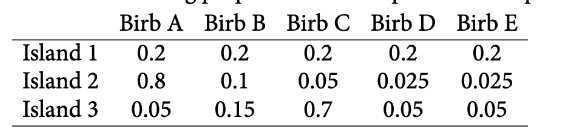

>Notice that each row sums to 1, all the birbs. This problem has two parts. It is not computationally complicated. But it is conceptually tricky. First, compute the entropy of each island’s birb distribution. Interpret these entropy values. Second, use each island’s birb distribution to predict the other two. This means to compute the K-L Divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different K-L Divergence values. Which island predicts the others best? Why?


In [2]:
df_data = pd.DataFrame({'Bird A': [0.2,0.8,0.05], 'Bird B': [0.2,0.1,0.15], 'Bird C': [0.2,0.05,0.7], 'Bird D': [0.2,0.025,0.05], 'Bird E': [0.2,0.025,0.05]}, index=['Island 1','Island 2','Island 3'])
df_data

,Bird A,Bird B,Bird C,Bird D,Bird E
Island 1,0.20,0.20,0.20,0.200,0.200
Island 2,0.80,0.10,0.05,0.025,0.025
Island 3,0.05,0.15,0.70,0.050,0.050


In [3]:
df_data = df_data.assign(entropy=df_data.apply(entropy, axis=1),
               kl_1=df_data.apply(entropy, axis=1, qk = (df_data.iloc[0].values)),
               kl_2=df_data.apply(entropy, axis=1, qk = (df_data.iloc[1].values)),
               kl_3=df_data.apply(entropy, axis=1, qk = (df_data.iloc[2].values)))

In [4]:
df_data

,Bird A,Bird B,Bird C,Bird D,Bird E,entropy,kl_1,kl_2,kl_3
Island 1,0.20,0.20,0.20,0.200,0.200,1.609438,0.000000,0.970406,0.638760
Island 2,0.80,0.10,0.05,0.025,0.025,0.743004,0.866434,0.000000,2.010914
Island 3,0.05,0.15,0.70,0.050,0.050,0.983600,0.625838,1.838845,0.000000


Entropy column tells you the entropy for each island and kl_x column tells the kl distance from island x from island y for $y\in(1..3)$. Which means it tells you how good of guess is island x distribution for island's y distirbution. 

As expected Island 1 has the highest entropy as it has most even distribution. Again you can see kl_1 column has lowest divergences as island 1 has highest entropy so is less surprised by values in other islands. 

***No total causal effect of area on weight***

### Question 2

>Recall the marriage, age, and happiness collider bias example from Chapter 6. Run models m6.9 and m6.10 again. Compare these two models using WAIC (or LOO, they will produce identical results). Which model is expected to make better predictions? Which model provides the correct causal inference about the influence of age on happiness? Can you explain why the answers to these two questions disagree?

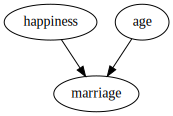

In [5]:
happiness = CausalGraphicalModel(
    nodes=["happiness", "marriage", "age"],
    edges=[
        ("happiness", "marriage"), 
        ("age", "marriage")
    ]
)
happiness.draw()

I have ended up getting data from R package and saving it in the data folder; reading it now and performing the edits done in the code from book

In [6]:
df_data = pd.read_csv("../data/happiness.csv")
print(df_data.describe())
df_data = df_data[df_data.age>17] # getting adults
df_data = df_data.assign(modified_age = (df_data.age - 18)/(65-18))
print(df_data.describe())

               age      married     happiness
count  1300.000000  1300.000000  1.300000e+03
mean     33.000000     0.300769 -9.018427e-17
std      18.768883     0.458769  1.214421e+00
min       1.000000     0.000000 -2.000000e+00
25%      17.000000     0.000000 -1.000000e+00
50%      33.000000     0.000000 -1.110223e-16
75%      49.000000     1.000000  1.000000e+00
max      65.000000     1.000000  2.000000e+00
             age     married     happiness  modified_age
count  960.00000  960.000000  9.600000e+02    960.000000
mean    41.50000    0.407292 -8.881784e-17      0.500000
std     13.86062    0.491586  1.214587e+00      0.294907
min     18.00000    0.000000 -2.000000e+00      0.000000
25%     29.75000    0.000000 -1.000000e+00      0.250000
50%     41.50000    0.000000 -1.110223e-16      0.500000
75%     53.25000    1.000000  1.000000e+00      0.750000
max     65.00000    1.000000  2.000000e+00      1.000000


In [7]:
def model6_9(age, married, happiness=None):
    n = len(set(married))
    alpha = numpyro.sample("alpha", dist.Normal(0,1), sample_shape=(n,))
    beta = numpyro.sample("beta", dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic('mu', alpha[married] + beta * age)
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)
def model6_10(age, happiness=None):
    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    beta = numpyro.sample("beta", dist.Normal(0, 2))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic('mu', alpha + beta * age)
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

In [8]:
kernel6_9 = NUTS(model6_9)
m6_9 = MCMC(kernel6_9, num_warmup=1000, num_samples=2000,num_chains=4,progress_bar=False)
m6_9.run(rng_key, age = df_data.modified_age.values, married = df_data.married.values, happiness=df_data.happiness.values)
m6_9.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.24      0.06     -0.24     -0.33     -0.12   2601.73      1.00
  alpha[1]      1.26      0.09      1.26      1.12      1.39   2582.98      1.00
      beta     -0.75      0.11     -0.75     -0.93     -0.56   2264.58      1.00
     sigma      0.99      0.02      0.99      0.96      1.03   4972.01      1.00

Number of divergences: 0


In [9]:
kernel6_10 = NUTS(model6_10)
m6_10 = MCMC(kernel6_10, num_warmup=1000, num_samples=2000,num_chains=4,progress_bar=False)
m6_10.run(rng_key, age = df_data.modified_age.values, happiness=df_data.happiness.values)
m6_10.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.08     -0.00     -0.13      0.13   2429.78      1.00
      beta      0.00      0.13      0.00     -0.23      0.21   2489.96      1.00
     sigma      1.22      0.03      1.22      1.17      1.26   4679.18      1.00

Number of divergences: 0


In [10]:
az.compare({'model6_9': m6_9,
            'model6_10': m6_10},
            scale='deviance')

/Users/smishra/anaconda3/envs/statrethinking/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model6_9,0,2713.805210,3.630965,0.000000,0.992348,37.316992,0.000000,False,deviance
model6_10,1,3101.917234,2.347816,388.112024,0.007652,27.633863,35.168188,False,deviance


Basically we have model with wrong causal inference doing better prediction, it is expected here if you look at causal graph knowing marriage is useful for predicting happiness but that doesn't give us right causal effect for age. To get causal effect of age if we condition on marriage in our model then path gets openend up as it is a collider.

### Question 3

>Reconsider the urban fox analysis from last week’s homework. Use WAIC or LOO based model comparison on five different models, each using weight as the outcome, and containing these sets of predictor variables:
> * avgfood + groupsize + area
> * avgfood + groupsize
> * groupsize + area
> * avgfood
> * area

>Can you explain the relative differences in WAIC scores, using the fox DAG from last week’s homework? Be sure to pay attention to the standard error of the score differences (dSE).

> 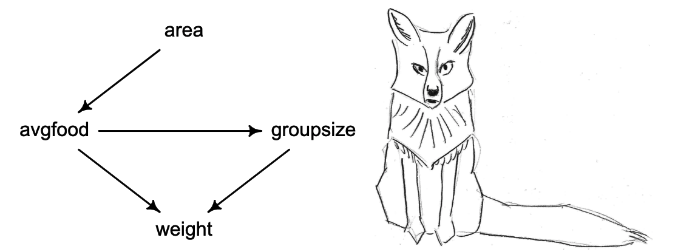


In [11]:
df_data = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', delimiter=';')
df_data[['avgfood', 'groupsize', 'area', 'weight']] = (df_data[['avgfood', 'groupsize', 'area', 'weight']] - df_data[['avgfood', 'groupsize', 'area', 'weight']].mean())/df_data[['avgfood', 'groupsize', 'area', 'weight']].std()
df_data

,group,avgfood,groupsize,area,weight
0,1,-1.924829,-1.524089,-2.239596,0.414135
1,1,-1.924829,-1.524089,-2.239596,-1.427046
2,2,-1.118035,-1.524089,-1.205508,0.675954
3,2,-1.118035,-1.524089,-1.205508,1.300942
4,3,-1.319734,-1.524089,-1.130106,1.115135
...,...,...,...,...,...
111,29,-0.412091,-0.224131,-0.451485,0.236773
112,29,-0.412091,-0.224131,-0.451485,-0.498010
113,30,-1.723131,-0.874110,-1.356312,-1.156781
114,30,-1.723131,-0.874110,-1.356312,-1.477721


In [12]:
X1 = df_data[['avgfood', 'groupsize', 'area']]
X2 = df_data[['avgfood', 'groupsize']]
X3 = df_data[['groupsize', 'area']]
X4 = df_data[['avgfood']]
X5 = df_data[['area']]

In [13]:
def model(X, weight=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(0,0.5))
    beta = numpyro.sample('beta', dist.Normal(0,0.5), sample_shape=(X.shape[1],))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    # likelihood
    mu = numpyro.deterministic('mu', alpha + X.dot(beta))
    numpyro.sample('weight_hat', dist.Normal(mu,sigma), obs=weight)

In [14]:
def run_model(X):
    # Run NUTS
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4,progress_bar=False)
    mcmc.run(rng_key, X = np.array(X.values), weight=df_data.weight.values)
#     mcmc.print_summary()
    return mcmc

In [ ]:
m1 = run_model(X1)
m2 = run_model(X2)
m3 = run_model(X3)
m4 = run_model(X4)
m5 = run_model(X5)

In [ ]:
az.compare({'model_1': m1,
            'model_2': m2,
            'model_3': m3,
            'model_4': m4,
            'model_5': m5},ic='loo' ,scale='deviance')

In [ ]:
az.compare({'model_1': m1,
            'model_2': m2,
            'model_3': m3,
            'model_4': m4,
            'model_5': m5},ic='waic' ,scale='deviance')

Remember best prediction doesn't mean best causal model. Always a problem you need to know about, if you are not worried about interventions it doesn't matter use `loo` or '=`waic` for selecting models but if interventions then you need causal graph. 